In [6]:
import os
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use("default")

idx = pd.IndexSlice

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.lines import Line2D

intermittent = pd.Index(["solar", "onwind", "offwind-ac", "offwind-dc"])
conventional = pd.Index(["OCGT", "CCGT", "nuclear", "biomass", "allam"])

regions = (
    gpd.read_file(
        Path.cwd().parent /
        "resources" /
        "pypsa-fes" /
        "regions_onshore_elec_s_eso.geojson")
        .set_index("name")
        [["geometry"]]
)

non_gb = regions.loc[~regions.index.str.contains("GB")]
gb = regions.loc[regions.index.str.contains("GB")]

In [7]:
def get_lines(flexopts, year):

    base = Path.cwd().parent /"results" / "pypsa-fes" / "networks" / f"elec_s_ec_lhnd__{flexopts}_LW_{year}.nc"
    n = pypsa.Network(base)

    l = (l := n.lines).loc[l.bus0.str.contains("GB") & l.bus1.str.contains("GB")]
    l.loc[:, ["caplength"]] = l["s_nom_opt"].mul(l["length"] * 1e-3)

    return l[["bus0", "bus1", "length", "s_nom", "s_nom_opt", "caplength"]]



In [8]:
def get_renewable_capacity(flexopts, year):

    base = Path.cwd().parent /"results" / "pypsa-fes" / "networks" / f"elec_s_ec_lhnd__{flexopts}_LW_{year}.nc"
    n = pypsa.Network(base)

    g = n.generators.loc[
        (n.generators.bus.isin(gb.index)) &
        (n.generators.carrier.isin(intermittent))
    ]

    df = pd.DataFrame(index=gb.index, columns=intermittent)

    for carrier in intermittent:
        df[carrier] = g.loc[g.carrier == carrier].groupby("bus").p_nom_opt.sum().mul(1e-3)

    df = df.fillna(0)
    return df.stack()



In [9]:
indexes = {
    "int": intermittent+"_energy",
    "cap": conventional+"_p_nom",
    "tra": "transmission_p_nom",
    "dis": "distribution_p_nom",
}

INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
C:\Users\lukas\AppData\Local\Temp\ipykernel_30472\874273014.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb_ax.set_yticklabels(labels)
C:\Users\lukas\AppData\Local\Temp\ipykernel_30472\874273014.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb_ax.set_yticklabels(labels)
C:\Users\lukas\AppData\Local\Temp\ipykernel_30472\874273014.py:240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


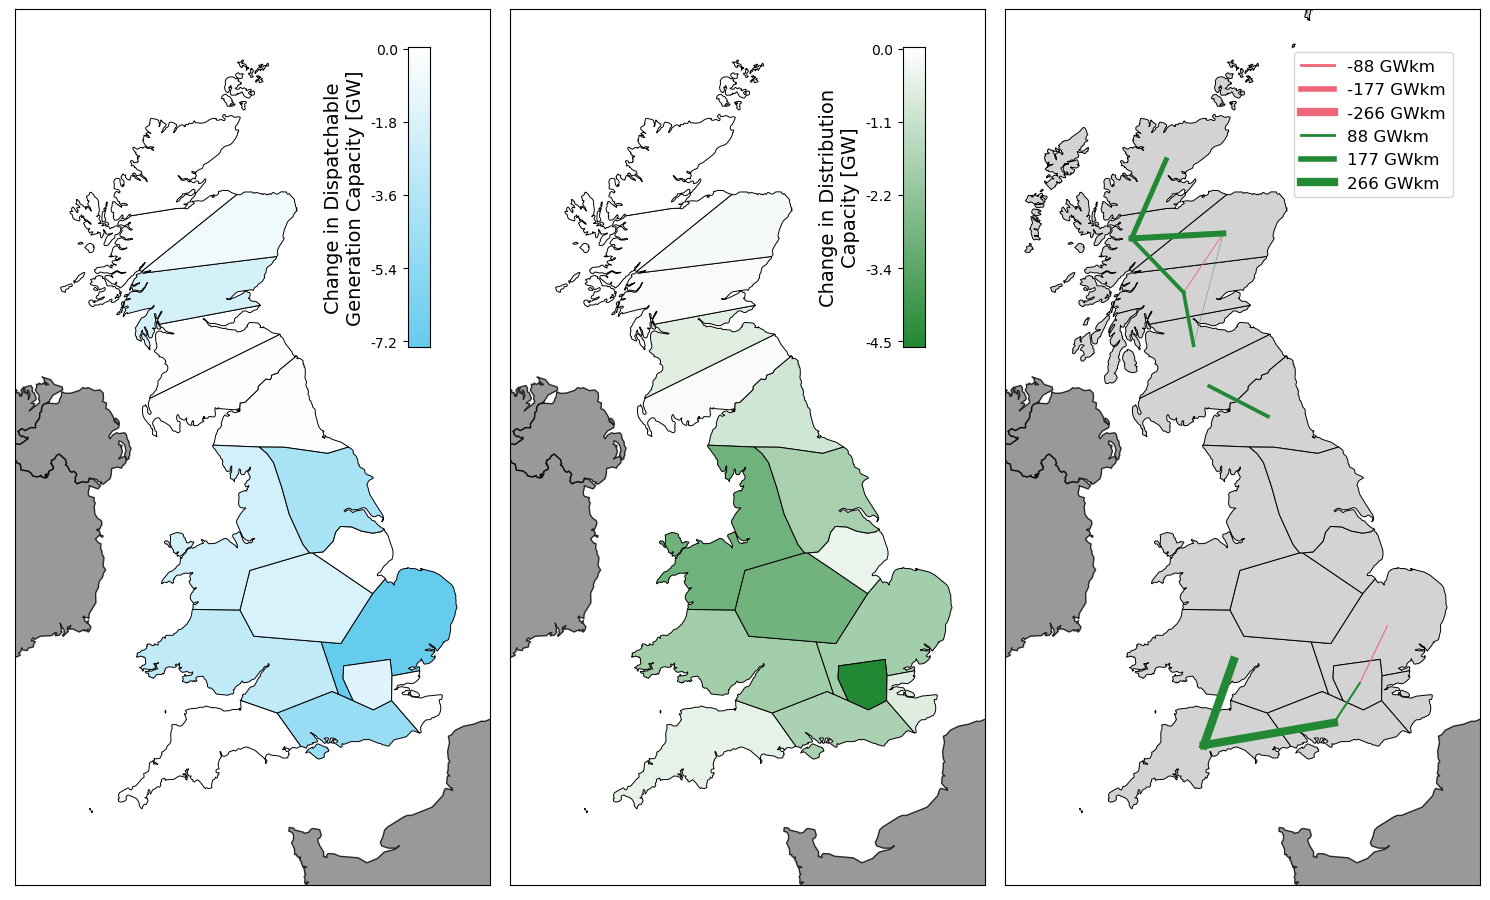

In [122]:
year = "2040"

no_flex_lines = get_lines("", year)
flex_lines = get_lines("int-tank-ss-v2g", year)

diff = pd.concat((
    flex_lines[["bus0", "bus1", "length", "s_nom"]],
    no_flex_lines["caplength"] - flex_lines["caplength"],
    no_flex_lines["s_nom_opt"] - flex_lines["s_nom_opt"],
    no_flex_lines["s_nom"].rename("base_expansion"),
), axis=1)

less_better = {
    "int": False,
    "cap": True,
    "dis": True,
}

# data = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics_combined.csv", index_col=[0,1], header=[0,1,2,3,4])
data = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics.csv", index_col=[0,1], header=[0,1,2,3,4])
data = data.loc[:, idx[:, :, :, :, year]]
cols = data.columns.droplevel([0,1,3,4]).to_frame()
cols.loc[cols.flexopts.str.contains("Unnamed"), "flexopts"] = "no flex"

data.columns = cols.set_index(["flexopts"]).index

data = (
    data
    .loc[:, ["no flex", "int-tank-ss-v2g"]]
    .rename(columns={"no flex": "no flex", "int-tank-ss-v2g": "flex"})
)

colors = ["#66CCEE", "#228833", "#CCBB44", "#EE6677"]
ylabels = {
    # "int": "Change in Use of\nIntermittent Generation [TWh]",
    "int": "Change in Renewable \nCapacity Factors [ ]",
    "cap": "Change in Dispatchable\nGeneration Capacity [GW]",
    "dis": "Change in Distribution\nCapacity [GW]",
}

to_cm = lambda c: LinearSegmentedColormap.from_list("Custom", ["white", c], N=100)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

for ax in axs: non_gb.plot(ax=ax, color="gray", alpha=0.8, edgecolor="black", linewidth=1.)

for i, name, ax in zip(range(2), ["cap", "dis"], axs):
    df = pd.DataFrame(columns=data.columns)

    if name == "int":
        factor = 1e-6
    else:
        factor = 1e-3

    for bus in data.index.get_level_values(0).unique():
        
        if name in ["int", "cap"]:
            df.loc[bus] = data.loc[idx[bus, indexes[name]], :].sum().mul(factor)
        else:
            df.loc[bus] = data.loc[idx[bus, indexes[name]], :].mul(factor)
        
    plot_data = pd.concat([
            gb,
            (df["no flex"] - df["flex"]).rename(name),
            # df["flex"].rename(name),
        ],
        axis=1)    
    
    if name != "int":
        cmap = to_cm(colors[i])
        vmin = 0.
    else:
        cmap = cm.get_cmap("coolwarm")
        vmin = None
    
    plot_data.plot(
        ax=ax,
        column=name,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.7,
        vmin=vmin,
    )

    offset = 0.275
    cb_ax = fig.add_axes([offset + i * 0.33, 0.6, 0.015, 0.3])
    cb_ax.set_xticklabels([])
    cb_ax.set_xticks([])

    y = np.atleast_2d(np.linspace(0, 1, 100)).T
    y = np.hstack((y, y))

    cb_ax.imshow(y, aspect='auto', cmap=cmap)

    cb_ax.set_ylabel(ylabels[name], fontsize=14)

    cb_ax.yaxis.set_major_locator(ticker.MultipleLocator(len(y) / 4.1))
    labels = cb_ax.get_yticklabels()
    
    if vmin is None:
        labels = [0.0] + np.around(-1. * np.linspace(plot_data[name].min(), plot_data[name].max(), len(labels) - 2), decimals=1).tolist()
    else:
        labels = [0.0] + np.around(np.linspace(0., -plot_data[name].max(), len(labels) - 2), decimals=1).tolist()
    cb_ax.set_yticklabels(labels)
    

gb.plot(ax=axs[2], color="lightgrey", edgecolor="black", linewidth=0.7)

normalizer = diff["caplength"].abs().max()
max_width = 6

my_lines = []
my_labels = []

for factor, color in zip([1., -1], [colors[3], colors[1]]):
    for i, row in diff.iterrows():

        if row.caplength * factor < 0:
            continue        

        bus0_centroid = regions.loc[row["bus0"]].geometry.centroid
        bus1_centroid = regions.loc[row["bus1"]].geometry.centroid

        axs[2].plot(
            [bus0_centroid.x, bus1_centroid.x],
            [bus0_centroid.y, bus1_centroid.y],
            color=color,
            linewidth=factor * row.caplength / normalizer * max_width,
            alpha=1,
            )

    my_lines += [
        Line2D([0], [0], color=color, lw=max_width * 1/3),
        Line2D([0], [0], color=color, lw=max_width * 2/3),
        Line2D([0], [0], color=color, lw=max_width)
        ]
    my_labels += [
            f"{int(factor * (-1) * normalizer * 1/3)} GWkm",
            f"{int(factor * (-1) * normalizer * 2/3)} GWkm",
            f"{int(factor * (-1) * normalizer)} GWkm",
        ]

axs[2].legend(
    my_lines,
    my_labels,
    bbox_to_anchor=(0.96, 0.96),
    fontsize=12,
    )


"""
renewable_gen_flex = get_renewable_capacity("int-tank-ss-v2g", year)
renewable_gen_noflex = get_renewable_capacity("", year)

values = {}

for bus in renewable_gen_flex.index.get_level_values(0).unique():

    flecap = renewable_gen_flex.loc[idx[bus], :]
    nofcap = renewable_gen_noflex.loc[idx[bus], :]

    try:
        energy = data.loc[idx[bus, indexes["int"]], :].mul(1e-3)
    except KeyError:
        continue

    energy.index = energy.index.get_level_values(1)

    capacity = pd.concat((
        nofcap.rename("no flex"),
        flecap.rename("flex"),
    ), axis=1
    )

    capacity.index = capacity.index + "_energy"

    cfs = energy.div(capacity * 8670)
    cfs = cfs["flex"] - cfs["no flex"]

    cfs = cfs.loc[~cfs.isna()]

    energy = energy.loc[cfs.index, "no flex"]

    weighted = np.average(cfs.values, weights=energy.values) * 100

    # weighted = cfs.loc["onwind_energy"] * 100
    # print(f"{bus}: {np.around(weighted, decimals=2)}")

    values[bus] = weighted

cfs_plotdata = pd.concat((gb, pd.Series(values, name="cfs")), axis=1)

cmap = to_cm(colors[0])

cfs_plotdata.plot(
    ax=axs[0],
    column="cfs",
    cmap=cmap,
    edgecolor="black",
    linewidth=0.7,
    vmin=vmin,
)

offset = 0.215
cb_ax = fig.add_axes([offset, 0.6, 0.015, 0.3])
cb_ax.set_xticklabels([])
cb_ax.set_xticks([])

y = np.atleast_2d(np.linspace(0, 1, 100)).T
y = np.hstack((y, y))

cb_ax.imshow(y, aspect='auto', cmap=cmap)

cb_ax.set_ylabel(ylabels["int"], fontsize=14)

cb_ax.yaxis.set_major_locator(ticker.MultipleLocator(len(y) / 4.1))
labels = cb_ax.get_yticklabels()

# labels = [0.0] + np.around(-1. * np.linspace(plot_data[name].min(), plot_data[name].max(), len(labels) - 2), decimals=1).tolist()
labels = np.around(
    np.linspace(
        cfs_plotdata["cfs"].min(),
        cfs_plotdata["cfs"].max(),
        len(labels) - 2),
    decimals=1).tolist()

cb_ax.set_yticklabels(labels)
"""

for ax in axs:

    ax.set_xlim(-8, 2.5)
    ax.set_ylim(49, 60)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.savefig("flexibility_map.pdf", bbox_inches="tight")
plt.show()

In [59]:
year = 2025

nf = pypsa.Network(
    Path.cwd().parent /
    "results" / "pypsa-fes" / "networks" / "elec_s_ec_lhnd__{}_LW_{}.nc".format("int-tank-ss-v2g", year)
)
nn = pypsa.Network(
    Path.cwd().parent /
    "results" / "pypsa-fes" / "networks" / "elec_s_ec_lhnd__{}_LW_{}.nc".format("", year)
)

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


        bus0    bus1
Line                
30    GB0 Z5  GB0 Z6
flex lines 7797.887703371359
135.35214387127962
flex links 2250.0
                     bus0    bus1
Link                             
Western HVDC Link  GB0 Z5  GB0 Z9
-63.60889849863111
total
71.74324537264852
        bus0    bus1
Line                
30    GB0 Z5  GB0 Z6
no flex lines 7797.887703371359
125.14213273539038
no flex links 2250.0
                     bus0    bus1
Link                             
Western HVDC Link  GB0 Z5  GB0 Z9
-73.15337051438344
total
51.98876222100694


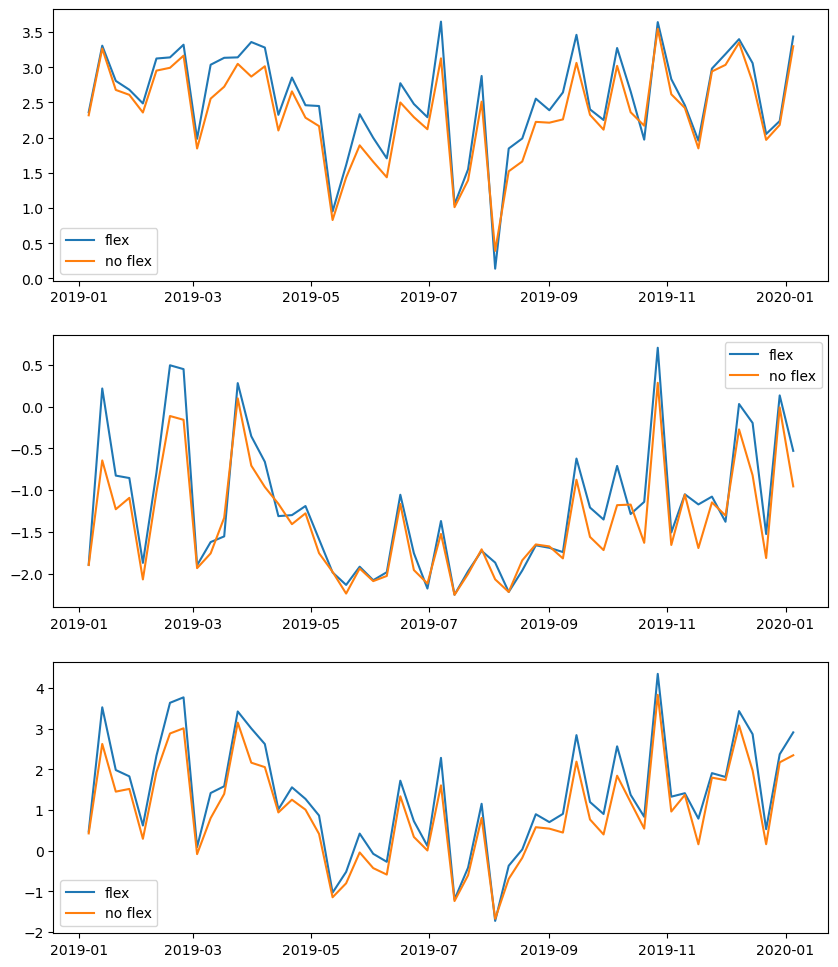

In [60]:

scot = ["GB0 Z1_1", "GB0 Z1_1", "GB0 Z1_3", "GB0 Z1_2", "GB0 Z1_4", "GB0 Z2", "GB0 Z3", "GB0 Z4", "GB0 Z5"]
rest = ["GB0 Z17"] + ["GB0 Z13", "GB0 Z9"] + ["GB0 Z16", "GB0 Z15", "GB0 Z14", "GB0 Z12"] + ["GB0 Z11", "GB0 Z10", "GB0 Z8", "GB0 Z7", "GB0 Z6"]

def get_l(n, c):

    l = getattr(n, c)

    one = l.loc[(l.bus0.isin(scot)) & (l.bus1.isin(rest))]
    two = l.loc[(l.bus1.isin(scot)) & (l.bus0.isin(rest))]

    return pd.concat((one, two))


fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for n, label in zip([nf, nn], ["flex", "no flex"]):

    lines = get_l(nf, "lines")
    print(lines[["bus0", "bus1"]])
    # ts = n.lines_t.p0.loc[:, lines.index].sum(axis=1).mul(1e-3).abs().resample("w").mean()
    linets = n.lines_t.p0.loc[:, lines.index].sum(axis=1).mul(1e-3).resample("w").mean()
    print(label, 'lines', lines.s_nom_opt.sum())
    print(linets.sum())

    axs[0].plot(linets, label=label)

    links = get_l(nf, "links")
    # ts = n.links_t.p0.loc[:, links.index].sum(axis=1).mul(1e-3).abs().resample("w").mean()
    linkts = n.links_t.p0.loc[:, links.index].sum(axis=1).mul(1e-3).resample("w").mean()
    print(label, 'links', links.p_nom_opt.sum())
    print(links[["bus0", "bus1"]])
    print(linkts.sum())
    print("total")
    print(linets.sum() + linkts.sum())

    axs[1].plot(linkts, label=label)

    total = linets + linkts
    axs[2].plot(total, label=label)


for ax in axs:
    ax.legend()

plt.show()


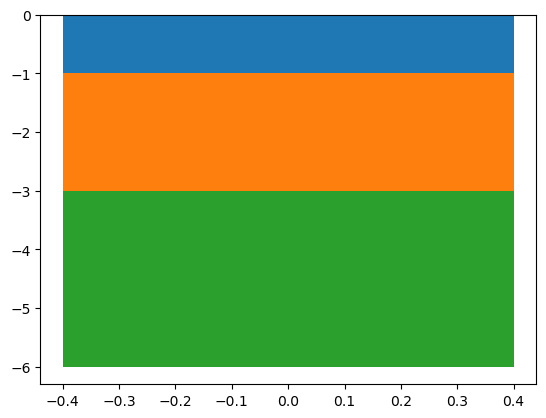

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

d = pd.Series([-1,-2,-3])

# plt.bar([1,2,3], 6, stacked=True)
# d.plot.bar(stacked=False)

fig, ax = plt.subplots()

for i, val in enumerate(d):
    ax.bar(0, val, bottom=d[:i].sum())

plt.show()


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported ne

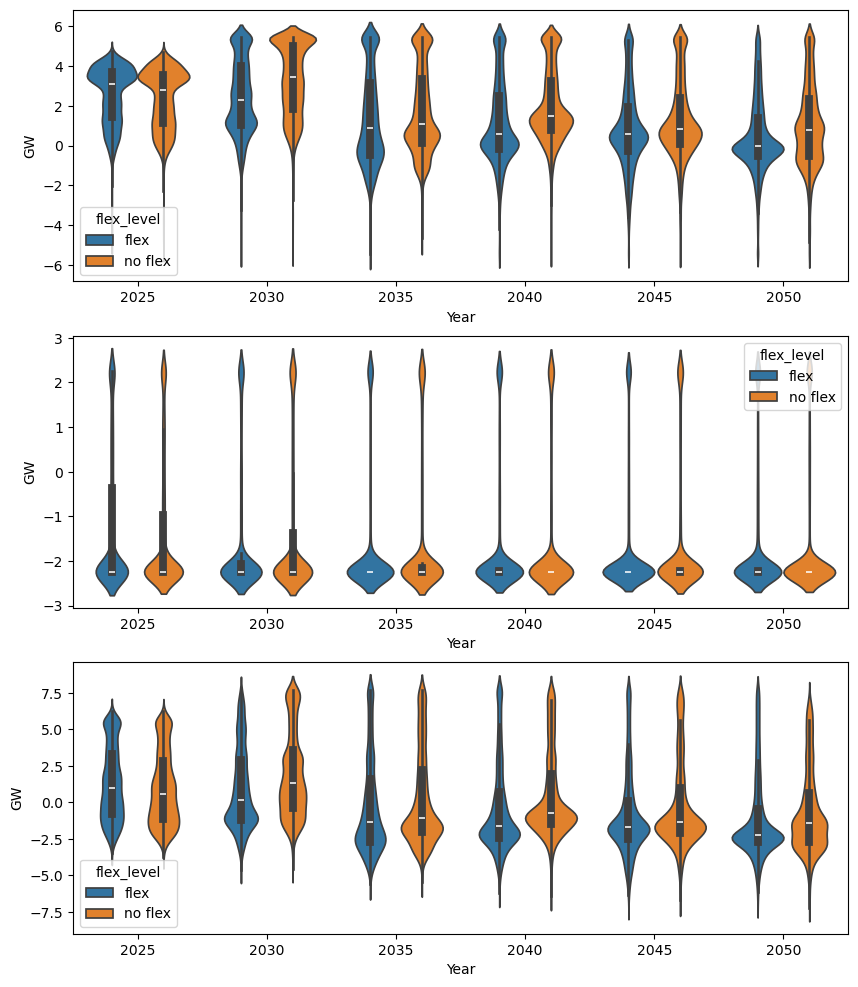

In [66]:

line_df = pd.DataFrame(columns=["data", "year", "flex_level"])
link_df = pd.DataFrame(columns=["data", "year", "flex_level"])
total_df = pd.DataFrame(columns=["data", "year", "flex_level"])

year_dfs = []

for year in [2025, 2030, 2035, 2040, 2045, 2050]:

    nf = pypsa.Network(
        Path.cwd().parent /
        "results" / "pypsa-fes" / "networks" / "elec_s_ec_lhnd__{}_LW_{}.nc".format("int-tank-ss-v2g", year)
    )
    nn = pypsa.Network(
        Path.cwd().parent /
        "results" / "pypsa-fes" / "networks" / "elec_s_ec_lhnd__{}_LW_{}.nc".format("", year)
    )

    for n, label in zip([nf, nn], ["flex", "no flex"]):

        lines = get_l(nf, "lines")
        linets = n.lines_t.p0.loc[:, lines.index].sum(axis=1).mul(1e-3)

        line_df = pd.concat((
            line_df,
            pd.DataFrame({
                "data": linets.values,
                "year": year,
                "flex_level": label,
            })))

        links = get_l(nf, "links")
        linkts = n.links_t.p0.loc[:, links.index].sum(axis=1).mul(1e-3)

        link_df = pd.concat((
            link_df,
            pd.DataFrame({
                "data": linkts.values,
                "year": year,
                "flex_level": label,
            })))

        total = linets + linkts
        total_df = pd.concat((
            total_df,
            pd.DataFrame({
                "data": total.values,
                "year": year,
                "flex_level": label,
            })))


In [71]:
total_df.loc[total_df.flex_level == "flex", "flex_level"] = "Flexible System"
total_df.loc[total_df.flex_level == "no flex", "flex_level"] = "Inflexible System"
total_df = total_df.rename(columns={"flex_level": ""})

(102, 204, 238)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


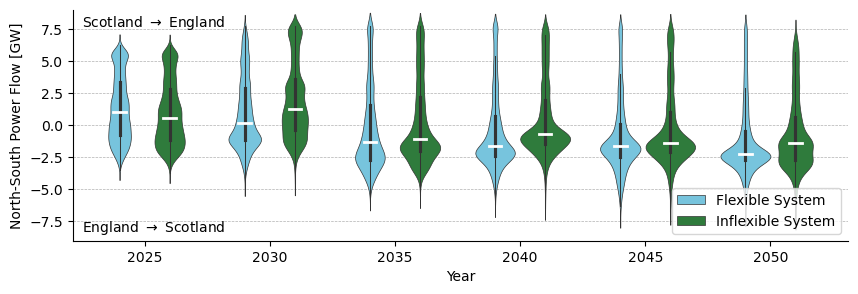

In [123]:
import seaborn as sns


to_color = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
print(to_color("66CCEE"))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

violin_kwargs = {
    "linewidth": 0.5,
    # "edgewidth": 1,
    "gap": 0,
    # "color": [to_color("66CCEE"), to_color("228833")]
    # "color": {
    #     "Flexible System": "#66CCEE",
    #     "Inflexible System": "#228833",
    #}
    "palette": ["#66CCEE", "#228833"], 
}

sns.violinplot(
    data=total_df,
    x="year",
    y="data",
    hue="",
    ax=ax,
    **violin_kwargs,
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, year in enumerate(total_df.year.unique()):

    flex_mean = total_df.loc[(total_df.year == year) & (total_df[""] == "Flexible System"), "data"].median()
    unflex_mean = total_df.loc[(total_df.year == year) & (total_df[""] == "Inflexible System"), "data"].median()

    offset = 0.2
    width = 0.05

    ax.plot([i - offset - width, i - offset + width], [flex_mean, flex_mean], color="white", linewidth=2)
    ax.plot([i + offset - width, i + offset + width], [unflex_mean, unflex_mean], color="white", linewidth=2)

ax.set_ylabel("North-South Power Flow [GW]")
ax.set_xlabel("Year")

ax.grid(axis="y", linestyle="--", linewidth=0.5)

ax.legend(loc="lower right")

ax.set_ylim(-9, 9)

ax.text(-0.5, -8, r"England $\rightarrow$ Scotland", fontsize=10, ha="left", va="center")
ax.text(-0.5, 8, r"Scotland $\rightarrow$ England", fontsize=10, ha="left", va="center")

ax.set_axisbelow(True)

plt.savefig("england_scotland_flow.pdf", bbox_inches="tight")
plt.show()


In [62]:
renewable_gen_flex = get_renewable_capacity("int-tank-ss-v2g", "2030")
renewable_gen_noflex = get_renewable_capacity("", "2030")

INFO:pypsa.io:Imported network elec_s_ec_lcopt__int-tank-ss-v2g_LW_2030.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lcopt___LW_2030.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


GB0 Z7: -15.92
GB0 Z6: 23.7
GB0 Z5: 5.72
GB0 Z3: 0.8
GB0 Z2: -4.09
GB0 Z1_4: -14.86
GB0 Z1_3: 32.07
GB0 Z12: -13.25
GB0 Z14: -8.47
GB0 Z15: 23.28
GB0 Z17: -5.94
GB0 Z16: -15.2
GB0 Z13: 6.8
GB0 Z11: -17.69
GB0 Z10: -2.44
GB0 Z9: -23.34
GB0 Z8: 8.87


<AxesSubplot:>

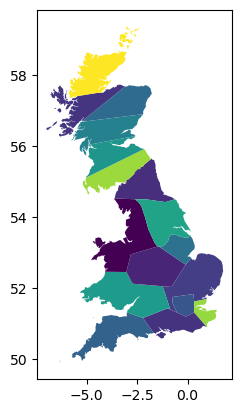

In [11]:
values = {}

for bus in renewable_gen_flex.index.get_level_values(0).unique():

    flecap = renewable_gen_flex.loc[idx[bus], :]
    nofcap = renewable_gen_noflex.loc[idx[bus], :]

    try:
        energy = data.loc[idx[bus, indexes["int"]], :].mul(1e-3)
    except KeyError:
        continue

    energy.index = energy.index.get_level_values(1)

    capacity = pd.concat((
        nofcap.rename("no flex"),
        flecap.rename("flex"),
    ), axis=1
    )

    capacity.index = capacity.index + "_energy"

    cfs = energy.div(capacity * 8670)
    cfs = cfs["flex"] - cfs["no flex"]

    cfs = cfs.loc[~cfs.isna()]

    energy = energy.loc[cfs.index, "no flex"]

    weighted = np.average(cfs.values, weights=energy.values) * 100
    weighted = cfs.loc["onwind_energy"] * 100

    print(f"{bus}: {np.around(weighted, decimals=2)}")

    values[bus] = weighted


pd.concat((gb, pd.Series(values, name="weighted")), axis=1).plot(column="weighted")

In [18]:
import os
import pandas as pd
import pypsa
from pathlib import Path
import numpy as np

In [21]:
os.listdir(Path.cwd().parent / "results" / "pypsa-fes" / "networks")
n = pypsa.Network(Path.cwd().parent / "results" / "pypsa-fes" / "networks" / "elec_s_ec_lhistoric___LW_2029.nc")

INFO:pypsa.io:Imported network elec_s_ec_lhistoric___LW_2029.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [22]:
(n.lines.s_nom_opt @ n.lines.capital_cost) / (n.lines.s_nom @ n.lines.capital_cost)

1.052509782920085